#### Packages used

In [1]:
from yahoofinancials import YahooFinancials
from hmmlearn.hmm import GaussianHMM
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

#### Download SPY, VIX data

In [17]:
start_date="2014-01-01"
end_date="2018-12-31"
time_interval="daily"

gspc = YahooFinancials("^GSPC")
gspc = gspc.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)

gspc = pd.DataFrame(gspc["^GSPC"]['prices'])
gspc = gspc.drop('date', axis=1).set_index('formatted_date')
gspc = gspc[["close"]]
gspc.columns = ["gspc"]

vix = YahooFinancials("^VIX")
vix = vix.get_historical_price_data(start_date=start_date, end_date=end_date, time_interval=time_interval)
vix = pd.DataFrame(vix["^VIX"]['prices'])
vix = vix.drop('date', axis=1).set_index('formatted_date')
vix = vix[["close"]]
vix.columns = ["vix"]

df = pd.concat([gspc, vix], axis=1)
df_shifted = df.drop(index=df.index[0], axis=0)
df_pct = df.pct_change()[1:]

#### Charts n Stuff

In [18]:
vix_fig = px.scatter(df_pct[["vix"]], title="VIX Daily % Change")
vix_fig.show()

#### HMM training and chart

In [19]:
# params
nRegimes = 3
nIter = 1000

In [20]:
# method to fit HMM to input data (ex. vix, rets, vix*rets)
def fitHMM(data, nRegimes, nIter):
    reshaped_data = np.reshape(data, [len(data),1])
    # fit HMM to data
    model = GaussianHMM(n_components=nRegimes, n_iter = nIter).fit(reshaped_data)

    # classify into states 
    hidden_states = model.predict(reshaped_data)
    
    # HMM params
    mu = np.array(model.means_)
    sigma = np.array(np.sqrt(np.array([np.diag(model.covars_[i]) for i in range(len(model.covars_))])))
    T = np.array(model.transmat_)

    # find log-likelihood of HMM
    prob = model.score(reshaped_data)
    return hidden_states, mu, sigma, T, prob

hidden_states, mu, sigma, T, prob = fitHMM(data=df[["vix"]], nRegimes=nRegimes, nIter=nIter)

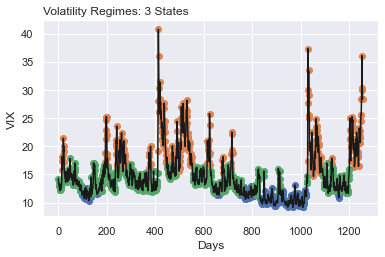

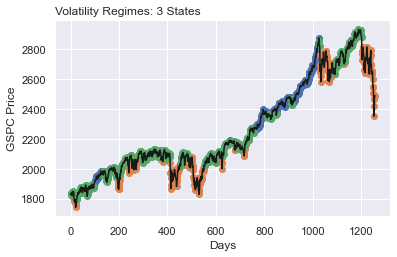

In [21]:
# plot the HMM states to a time series of the corresponding stock price
def plotHMM(data, hidden_states, ylabel, title):
    sns.set()
    fig = plt.figure()
    subplt = fig.add_subplot(1,1,1)
    x = np.arange(len(data))
    
    unique_states = np.unique(hidden_states)
    for i in range(len(unique_states)):
        masks = hidden_states == unique_states[i]
        subplt.scatter(x[masks], data[masks], label= " ".join(["State", str(i+1)]))

    subplt.plot(x, data, c="k")
     
    subplt.set_xlabel('Days')
    subplt.set_ylabel(ylabel)
    subplt.set_title(title, loc="left")
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    # fig.legend(handles, labels, ncol=2, frameon=True)
    plt.show() 
    return None


plotHMM(df[["vix"]], hidden_states, 'VIX', 'Volatility Regimes: '+str(nRegimes)+ ' States')
plotHMM(df[["gspc"]], hidden_states, 'GSPC Price', 'Volatility Regimes: '+str(nRegimes)+ ' States')

In [34]:
# figure out optimal number of regimes

# range of regimes to test
num_regimes = range(2,16)
# arr of test probabilities
prob_arr = []

for i in num_regimes:
    hidden_states, mu, sigma, T, prob = fitHMM(data=df[["vix"]], nRegimes=i, nIter=nIter)
    prob_arr.append(prob)

C:\Users\sidiy\AppData\Local\Temp/ipykernel_644/1047470231.py:6: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



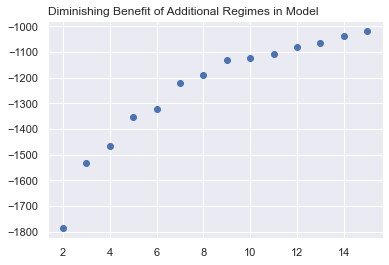

In [35]:
fig1 = plt.figure()
subplt1 = fig1.add_subplot(111)
subplt1.scatter(num_regimes,prob_arr)
subplt1.set_title("Diminishing Benefit of Additional Regimes in Model", loc="left")

fig1.show()